In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from matplotlib import cm
from datetime import datetime,time, tzinfo, timedelta

In [31]:
sun_model_df = pd.read_csv('Sun_weight.csv',index_col=0)
Input = pd.read_csv('Window.csv',index_col=0)
Output = pd.read_csv('Work_surf.csv',index_col=0)
area_pos = sun_model_df[['x','y']]

In [112]:
sun_model_df

2W      2R_B      2L_B      2L_F     1test          x         y
1a  0.000000  0.000000  0.000000  0.120622  0.001318  -0.000953  9.454699
1b  0.107376  0.003805  0.000000  0.042508  0.000123   5.132275  9.269297
1c  0.000000  0.004380  0.000000  0.089595  0.000881  10.066726  9.212748
1d  0.000000  0.001501  0.000000  0.068672  0.002212   2.475253  7.623279
1e  0.000000  0.002068  0.000000  0.067316  0.002133   7.682209  7.559709
1f  0.000000  0.004719  0.000000  0.038833  0.003463   2.637604  4.491495
1g  0.000000  0.008647  0.000000  0.027861  0.004645   7.603032  4.415997
1h  0.000000  0.000168  0.017308  0.037048  0.028287   2.544968  1.418191
1i  0.000000  0.014471  0.000000  0.033253  0.027267   7.515120  1.416423
2a  0.000000  0.012731  0.110175  0.000000  0.027361  -0.085557 -0.007001
2b  0.000000  0.000000  0.121040  0.000000  0.047591   5.018680 -0.238415
2c  0.000000  0.052008  0.044348  0.000000  0.035798   9.943524 -0.141846
2d  0.000000  0.019328  0.000000  0.036109  0.007925  -0.071422  2.925390
2e  0.000000  0.010886  0.000000  0.039426  0.009462   5.208062  3.165729
2f  0.000000  0.018093  0.000000  0.033211  0.011619  10.094068  2.953074
2g  0.000000  0.003527  0.000000  0.041917  0.002971   0.099498  5.962246
2h  0.000000  0.003704  0.000000  0.051868  0.003244   5.180517  5.989242
2i  0.000000  0.004597  0.000000  0.043011  0.002690  10.206749  6.119578

In [32]:
sun_model_df

2W      2R_B      2L_B      2L_F     1test          x         y
1a  0.000000  0.000000  0.000000  0.120622  0.001318  -0.000953  9.454699
1b  0.107376  0.003805  0.000000  0.042508  0.000123   5.132275  9.269297
1c  0.000000  0.004380  0.000000  0.089595  0.000881  10.066726  9.212748
1d  0.000000  0.001501  0.000000  0.068672  0.002212   2.475253  7.623279
1e  0.000000  0.002068  0.000000  0.067316  0.002133   7.682209  7.559709
1f  0.000000  0.004719  0.000000  0.038833  0.003463   2.637604  4.491495
1g  0.000000  0.008647  0.000000  0.027861  0.004645   7.603032  4.415997
1h  0.000000  0.000168  0.017308  0.037048  0.028287   2.544968  1.418191
1i  0.000000  0.014471  0.000000  0.033253  0.027267   7.515120  1.416423
2a  0.000000  0.012731  0.110175  0.000000  0.027361  -0.085557 -0.007001
2b  0.000000  0.000000  0.121040  0.000000  0.047591   5.018680 -0.238415
2c  0.000000  0.052008  0.044348  0.000000  0.035798   9.943524 -0.141846
2d  0.000000  0.019328  0.000000  0.036109  0.007925  -0.071422  2.925390
2e  0.000000  0.010886  0.000000  0.039426  0.009462   5.208062  3.165729
2f  0.000000  0.018093  0.000000  0.033211  0.011619  10.094068  2.953074
2g  0.000000  0.003527  0.000000  0.041917  0.002971   0.099498  5.962246
2h  0.000000  0.003704  0.000000  0.051868  0.003244   5.180517  5.989242
2i  0.000000  0.004597  0.000000  0.043011  0.002690  10.206749  6.119578

In [114]:
def daylight_generate(sun_model,right=0,left=0,Real=False,sample=None,name='',delta=0.25,mn = [-2,-2],mx = [12,11]):
    #,model=model,sun_arr=sun_arr, ,mn = [-1,-2],mx = [10,11]):
    model = sun_model.copy()
    feature_col = model.columns[:-2]
    if not Real:
        in_ = [right]*3+[left]*2
        upper_left,center_left,lower_left,upper_right,center_right = in_
        sensor_mapping_dict = {
            '2W': center_right,
            '2R_B': lower_left,
            '2L_B': upper_left,
            '2L_F': upper_right,
            '1test': center_left
        }
        input_vector = np.array([sensor_mapping_dict[cc] for cc in feature_col])
    else:
        input_vector = np.array([sample[cc] for cc in feature_col])
    sun_arr = model[feature_col].values
    model['lux'] = sun_arr.dot(input_vector)
    
    new_X,new_Y = np.meshgrid(np.arange(mn[0], mx[0]+delta, delta), np.arange(mn[1], mx[1]+delta, delta))
    xflat = np.dstack((new_X.flatten(),new_Y.flatten()))[0]
    model_rbf = RBFInterpolator(model[['x','y']].values,model["lux"].values.reshape(-1,1),smoothing=1)
    yflat = model_rbf(xflat)
    y_grid = yflat.reshape(new_X.shape)

    fig = plt.figure(figsize=(12,6))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(name)
    # ax.set_title('Area: '+''lux")
    ax.plot_surface(new_Y,new_X, y_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=0.5)
    p = ax.scatter(model['y'],model['x'],model['lux'],c=model['lux'], s=50,ec='k',cmap=cm.coolwarm)
    for dd in model[['y','x','lux']].values:
        label = '{0:.3f}'.format(dd[2])
        ax.text(dd[0]+0.1, dd[1]+0.1, dd[2], label,color='black')
    fig.colorbar(p,shrink=0.5)
    ax.view_init(elev=90, azim=-90)
    plt.ylim( mx[0],mn[0])
    plt.xlim(mn[1],mx[1])#mn[1], 
    ax = fig.add_subplot(1, 2, 2)
    contours = ax.contour(new_Y,new_X,  y_grid, 40, cmap=cm.coolwarm)
    ax.set_aspect('equal', 'box')
    plt.ylim( mx[0],mn[0])
    plt.xlim(mn[1],mx[1])
    plt.show()

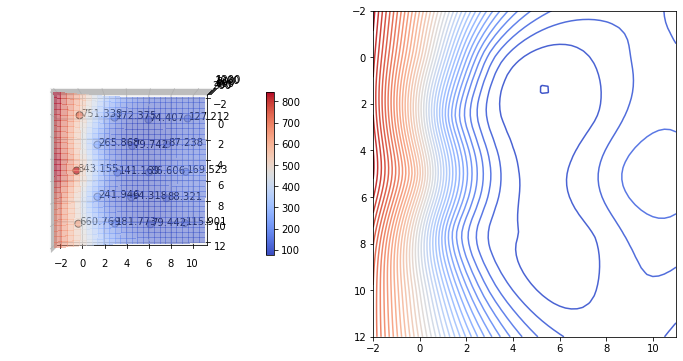

In [115]:
%matplotlib inline
daylight_generate(sun_model_df,5000,1000)

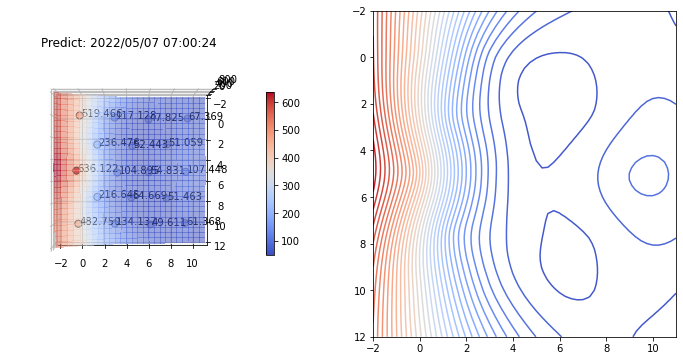

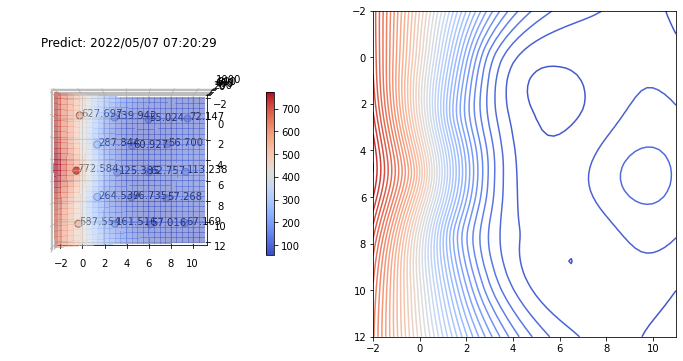

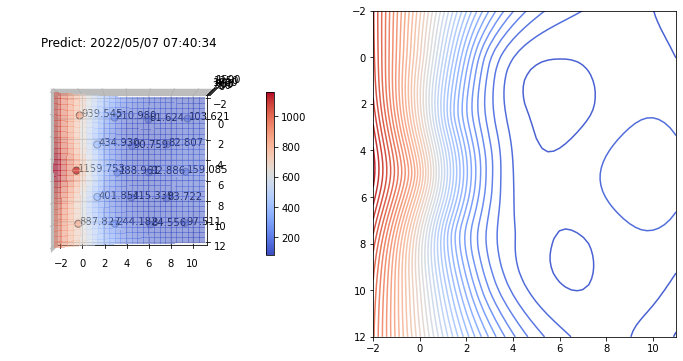

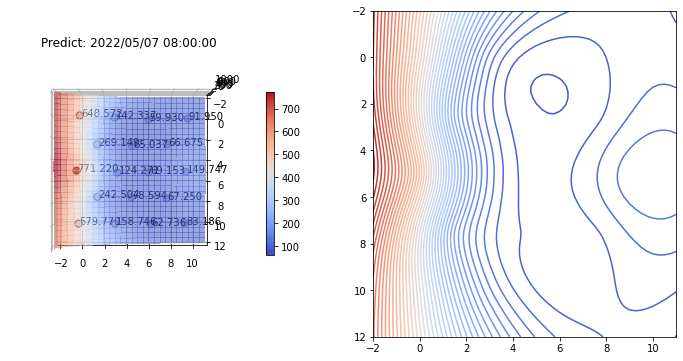

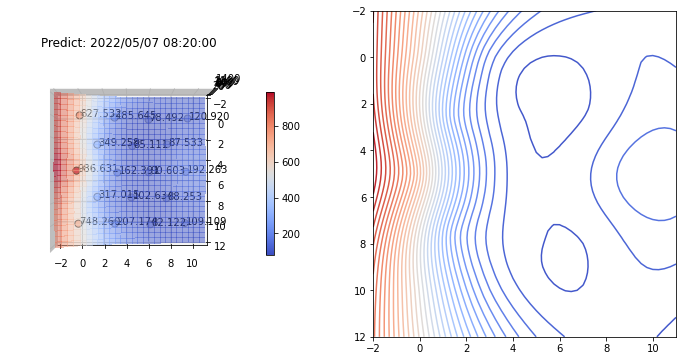

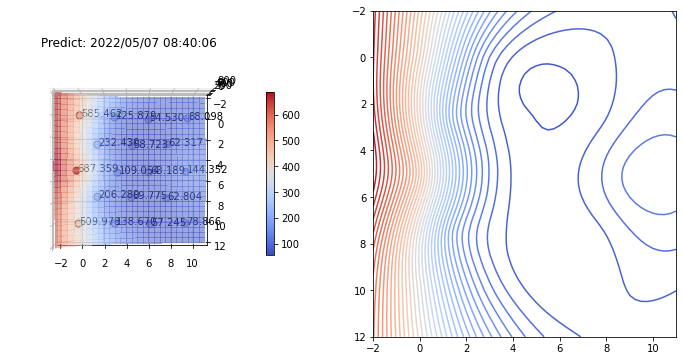

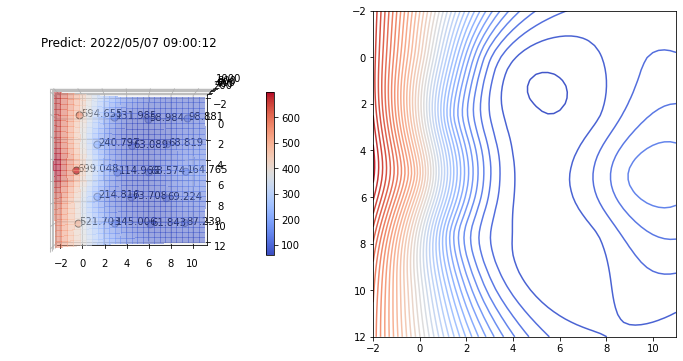

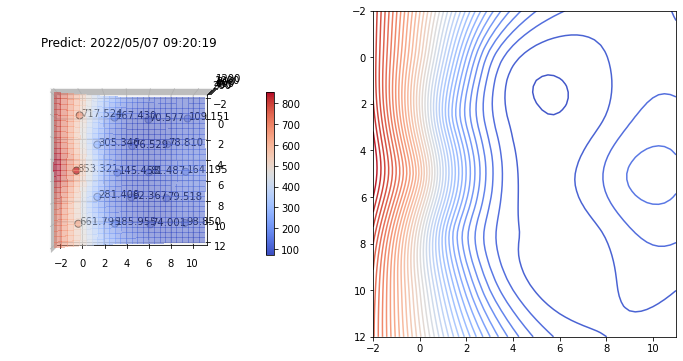

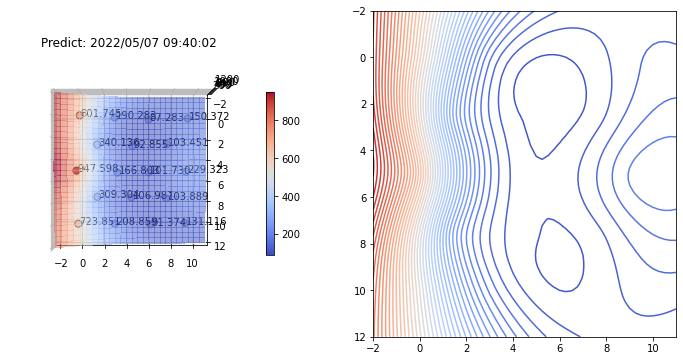

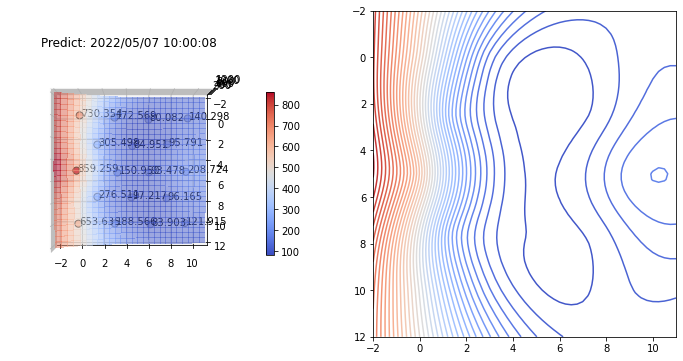

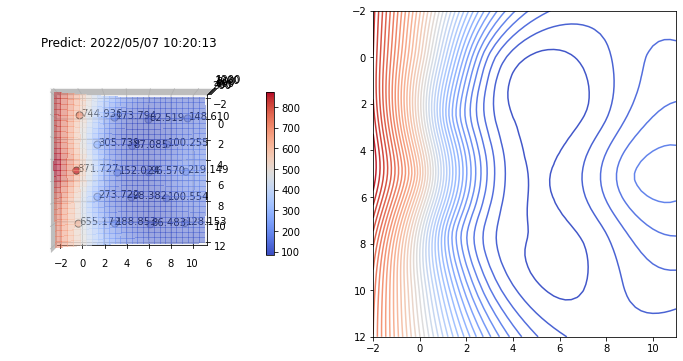

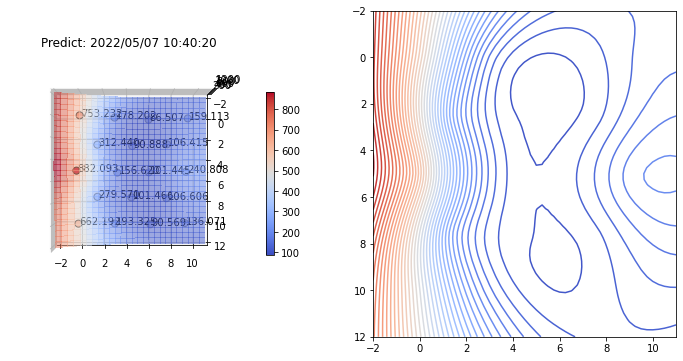

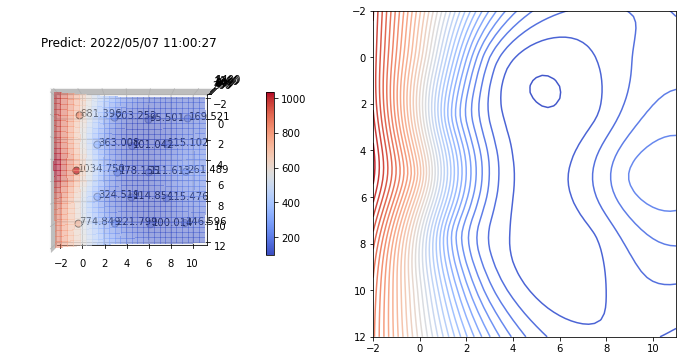

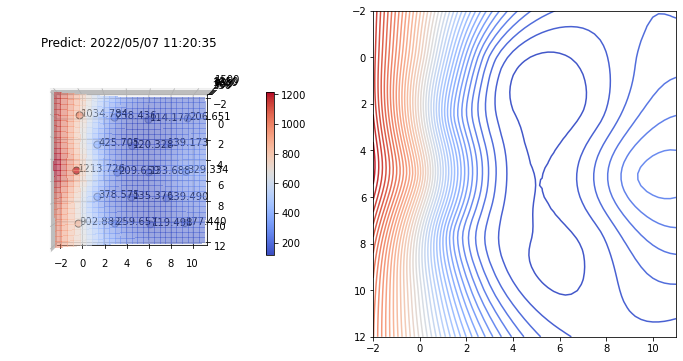

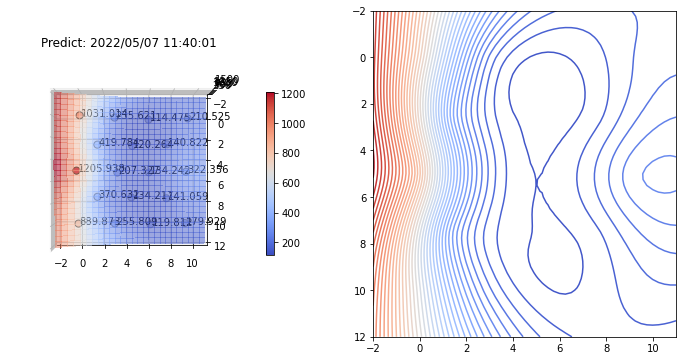

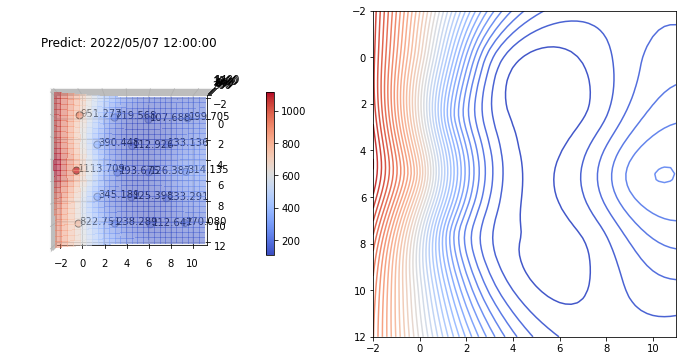

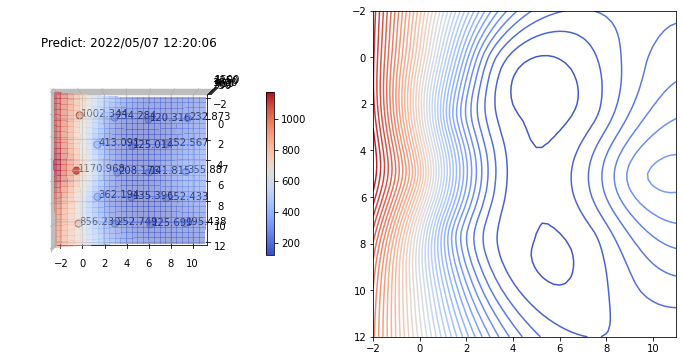

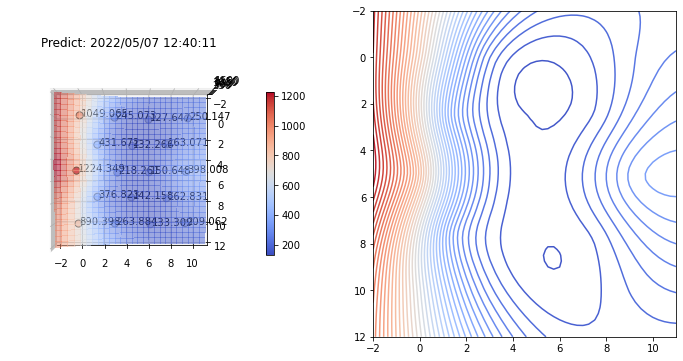

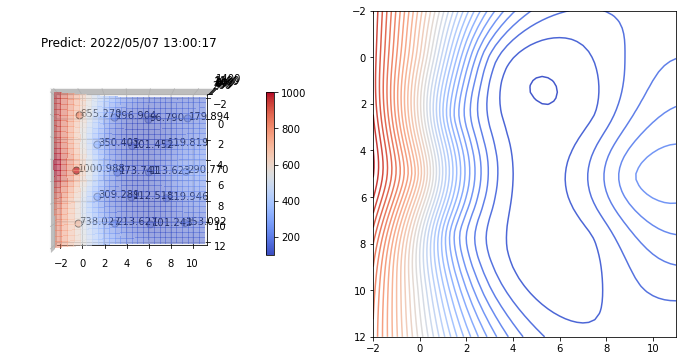

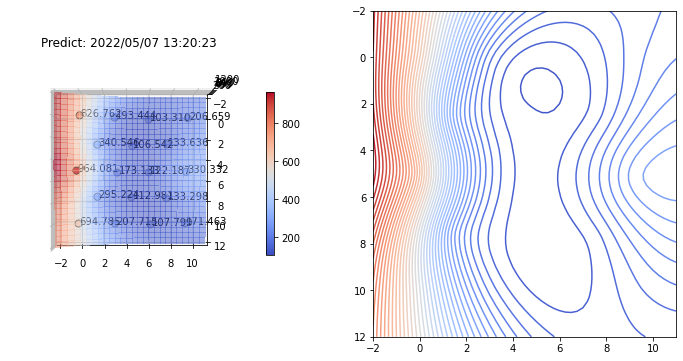

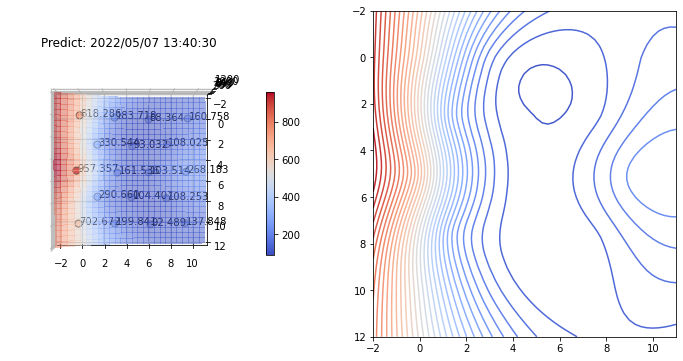

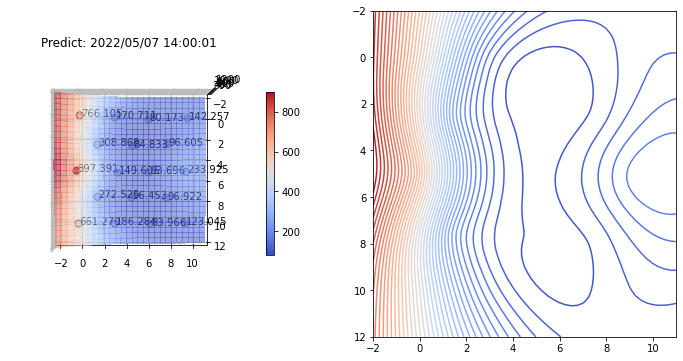

In [116]:
td2 = Time_point(Input)
for name,ss in td2.iterrows():
    daylight_generate(sun_model_df,name='Predict: '+name,Real=True,sample=ss)

# daylight_generate(sun_model_df,5000,1000)

In [122]:
def Real_suf(sun_model,area_pos,name='',delta=0.25,mn = [-2,-2],mx = [12,11]):
    sun_model = pd.merge(sun_model.to_frame(),area_pos,left_index=True,right_index=True,how='left').sort_index()
    sun_model.columns = ['lux','x','y']
    new_X,new_Y = np.meshgrid(np.arange(mn[0], mx[0]+delta, delta), np.arange(mn[1], mx[1]+delta, delta))
    xflat = np.dstack((new_X.flatten(),new_Y.flatten()))[0]
    model_rbf = RBFInterpolator(sun_model[['x','y']].values,sun_model["lux"].values.reshape(-1,1),smoothing=1)
    yflat = model_rbf(xflat)
    y_grid = yflat.reshape(new_X.shape)
    # if draw:
    fig = plt.figure(figsize=(12,6))
    # ax.title('Area: '+''lux")
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(name)
    # ax.set_title('Area: '+''lux")
    ax.plot_surface(new_Y,new_X, y_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=0.5)
    p = ax.scatter(sun_model['y'],sun_model['x'],sun_model['lux'],c=sun_model['lux'], 
                   s=50,ec='k',cmap=cm.coolwarm)
    for dd in sun_model[['y','x','lux']].values:
        label = '{0:.3f}'.format(dd[2])
        ax.text(dd[0]+0.1, dd[1]+0.1, dd[2], label,color='black')

    fig.colorbar(p,shrink=0.5)
    ax.view_init(elev=90, azim=-90)
    plt.ylim( mx[0],mn[0])
    plt.xlim(mn[1],mx[1])#mn[1], 
    ax = fig.add_subplot(1, 2, 2)
    contours = ax.contour(new_Y,new_X,  y_grid, 40, cmap=cm.coolwarm)
    ax.set_aspect('equal', 'box')
    plt.ylim( mx[0],mn[0])
    plt.xlim(mn[1],mx[1])
    plt.show()
    return y_grid

In [123]:
def Time_point(df):
    start_point = datetime(2022,5,7,7,0,0)
    time_ps2 = [ (start_point+timedelta(minutes=20*i)).strftime('%Y/%m/%d %H:%M:%S') for i in range(22)]
    ffs2 = df.dropna()
    time_df2 = pd.DataFrame([])
    for tp in time_ps2:
        if time_df2.empty:
            time_df2 = ffs2.loc[tp:].iloc[0:1]
        else:
            time_df2 = pd.concat([time_df2,ffs2.loc[tp:].iloc[0:1]])
    return time_df2

In [124]:
Time_point(Output)

1a          1b          1c          1d  \
2022/05/07 07:00:24   66.705232  109.335602   63.057519   50.972439   
2022/05/07 07:20:29   71.832038  113.537120   68.004357   55.587345   
2022/05/07 07:40:34  104.976555  160.330681   96.844618   84.148589   
2022/05/07 08:00:00   87.013816  147.870345   80.772282   62.988252   
2022/05/07 08:20:00  115.740956  190.366244  108.048326   85.465780   
2022/05/07 08:40:06   83.003178  144.370683   77.438544   59.567346   
2022/05/07 09:00:12   92.793296  164.109163   85.816884   64.182252   
2022/05/07 09:20:19  103.075285  161.609404  100.686727   79.135684   
2022/05/07 09:40:02  143.058697  224.997518  131.716892  104.493975   
2022/05/07 10:00:08  134.195565  202.018966  126.887370  100.172831   
2022/05/07 10:20:13  139.710192  210.047037  132.860726  103.337879   
2022/05/07 10:40:20  149.320589  237.563613  140.456957  108.132833   
2022/05/07 11:06:14  205.469519  304.960955  170.382394  138.248172   
2022/05/07 11:20:35  223.583603  337.515505  184.215943  147.819127   
2022/05/07 11:40:01  231.198139  338.717312  191.039842  154.158700   
2022/05/07 12:00:00  221.833678  326.814615  175.690957  147.032603   

                             1e          1f          1g          1h  \
2022/05/07 07:00:24   51.756773   52.219352   66.491951  249.312665   
2022/05/07 07:20:29   56.572238   59.854977   76.241861  288.997799   
2022/05/07 07:40:34   85.237528   90.775949  114.063657  416.342577   
2022/05/07 08:00:00   64.354713   60.924154   74.867712  273.681801   
2022/05/07 08:20:00   87.104943   82.392846  100.471741  344.925629   
2022/05/07 08:40:06   60.430298   54.556402   65.482373  235.086303   
2022/05/07 09:00:12   65.378473   57.517927   69.109377  237.866401   
2022/05/07 09:20:19   81.104570   76.649568   93.872090  305.515450   
2022/05/07 09:40:02  107.210459  100.691854  119.840688  352.105003   
2022/05/07 10:00:08  102.186450   95.705516  114.110397  324.304024   
2022/05/07 10:20:13  105.049187   98.515653  115.624764  331.300095   
2022/05/07 10:40:20  109.893090   96.670614  112.091240  315.892446   
2022/05/07 11:06:14  133.401661  118.404234  132.516505  408.205954   
2022/05/07 11:20:35  141.904559  125.065300  138.433756  424.489384   
2022/05/07 11:40:01  148.009204  129.275775  142.014020  422.982225   
2022/05/07 12:00:00  138.084417  121.621226  132.796944  385.873519   

                             1i          2a           2b          2c  \
2022/05/07 07:00:24  226.875239  528.708537   671.334518  508.231007   
2022/05/07 07:20:29  264.339871  631.613883   781.168896  589.622574   
2022/05/07 07:40:34  387.598413  906.569120  1118.540297  860.573949   
2022/05/07 08:00:00  245.473362  657.845028   811.785022  596.180329   
2022/05/07 08:20:00  315.233721  796.945580   981.215676  738.179049   
2022/05/07 08:40:06  205.464037  593.512674   737.104656  531.832974   
2022/05/07 09:00:12  210.493781  595.975382   741.749660  541.545595   
2022/05/07 09:20:19  284.647710  709.995941   868.021704  664.754014   
2022/05/07 09:40:02  331.466076  741.879048   916.059028  716.918429   
2022/05/07 10:00:08  306.973411  663.327149   816.371598  644.346597   
2022/05/07 10:20:13  307.003231  684.481906   847.786236  655.616809   
2022/05/07 10:40:20  291.218186  673.781864   835.487201  642.451693   
2022/05/07 11:06:14  363.284672  945.425182  1170.872059  867.171388   
2022/05/07 11:20:35  376.892813  984.158581  1218.198513  900.962182   
2022/05/07 11:40:01  372.598644  967.080030  1202.783333  880.971445   
2022/05/07 12:00:00  344.467864  880.611609  1102.696646  822.685797   

                             2d          2e          2f          2g  \
2022/05/07 07:00:24  121.220885  109.647775  141.544492   47.345577   
2022/05/07 07:20:29  140.662643  126.820343  163.191545   53.715916   
2022/05/07 07:40:34  208.036985  185.851656  237.831450   81.333378   
2022/05/07 08:00:00  137.374848  120.756555  155.998883   55.158973   
2022/05/07 08:20:00  178.711486  

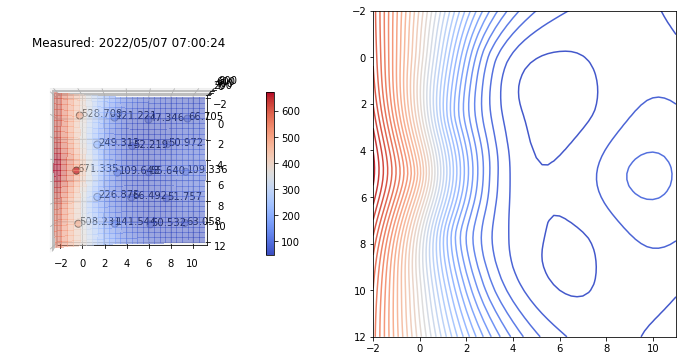

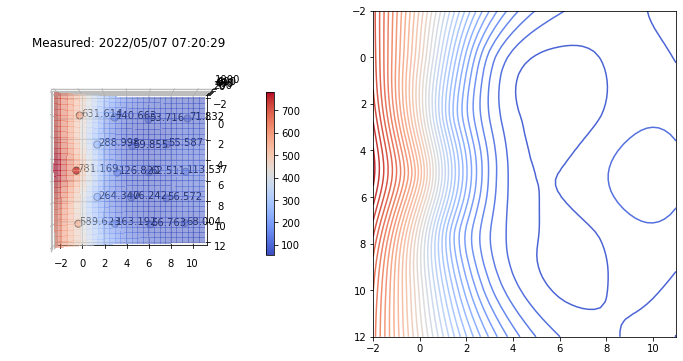

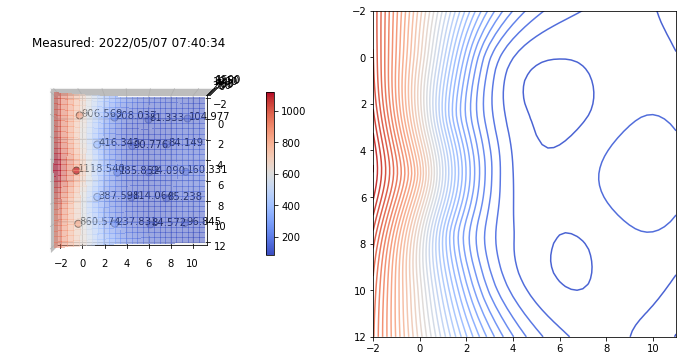

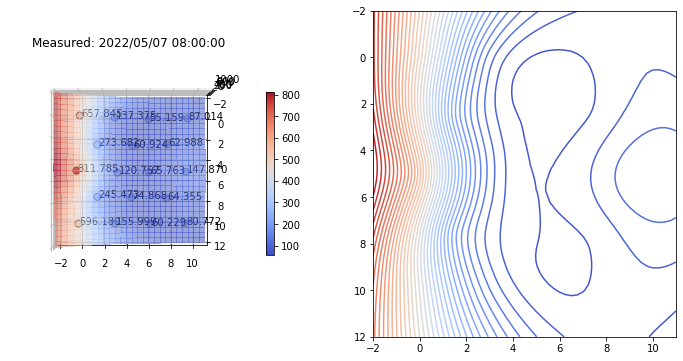

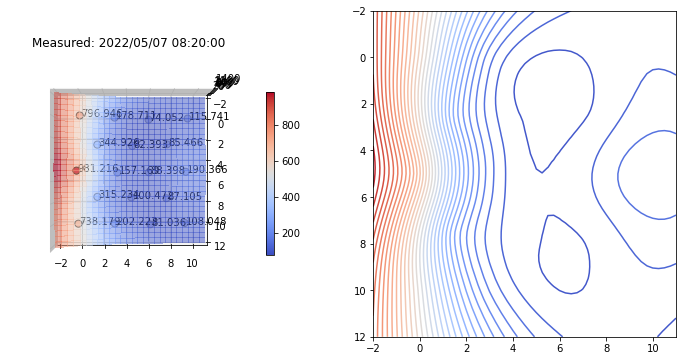

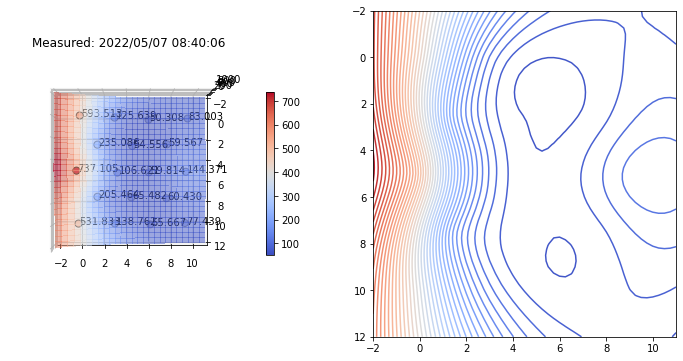

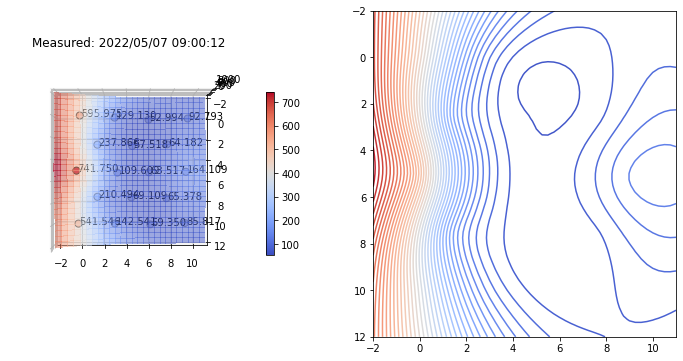

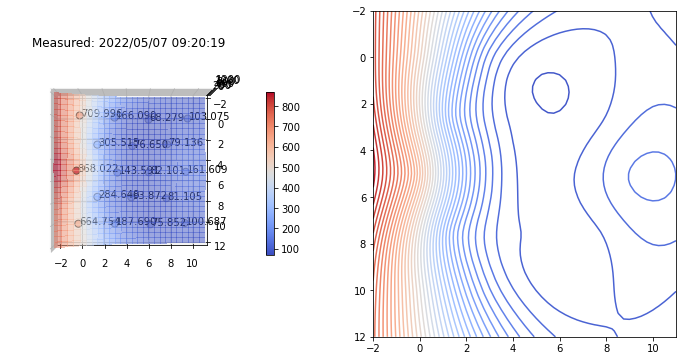

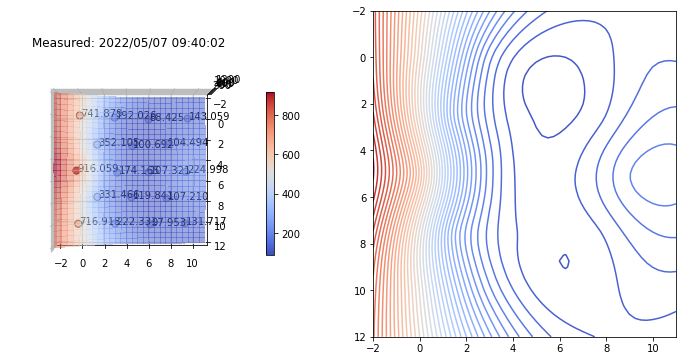

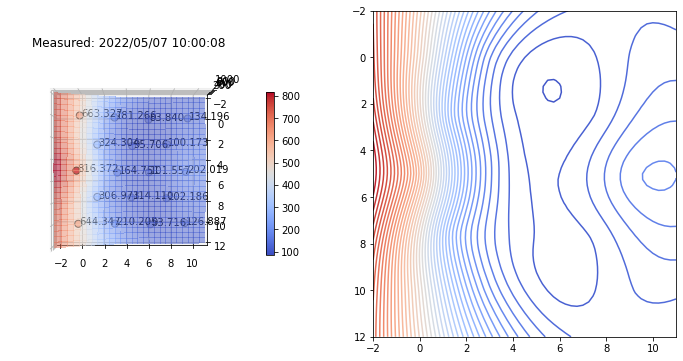

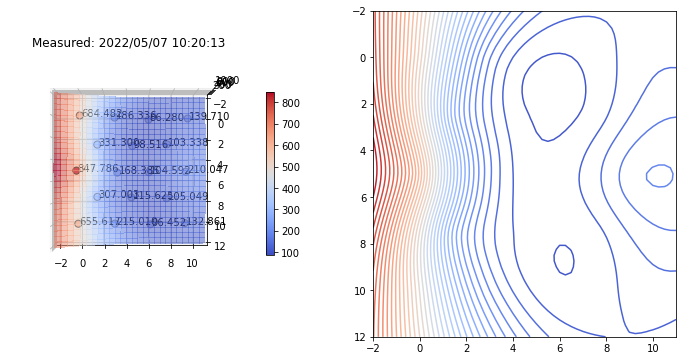

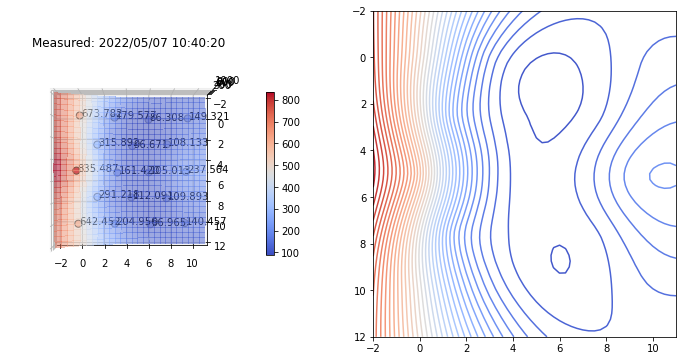

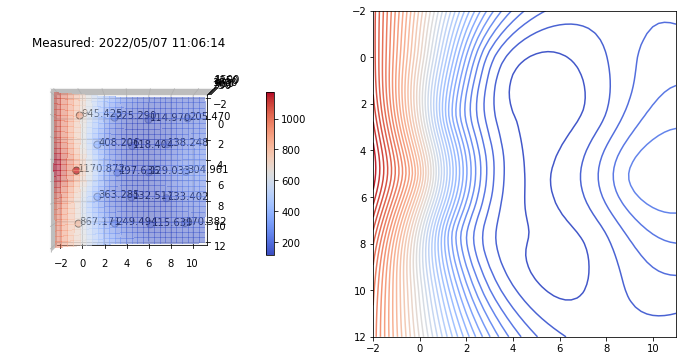

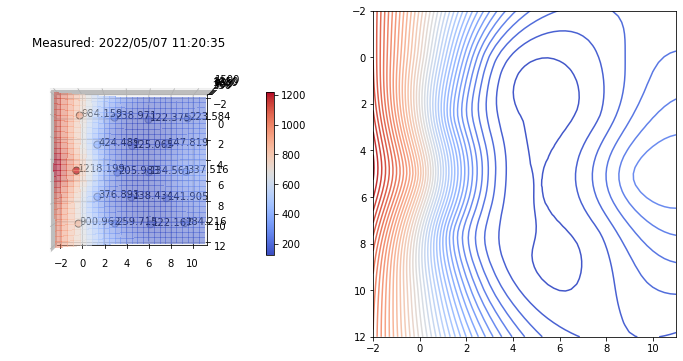

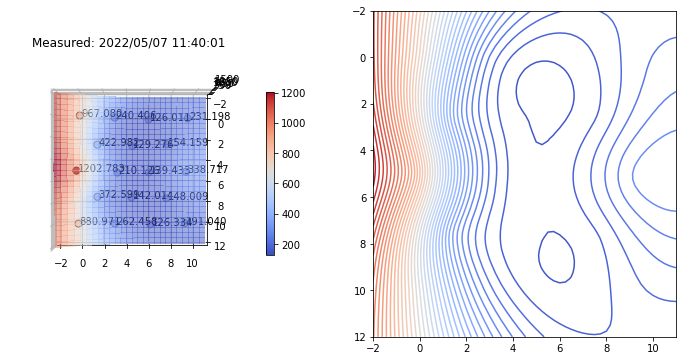

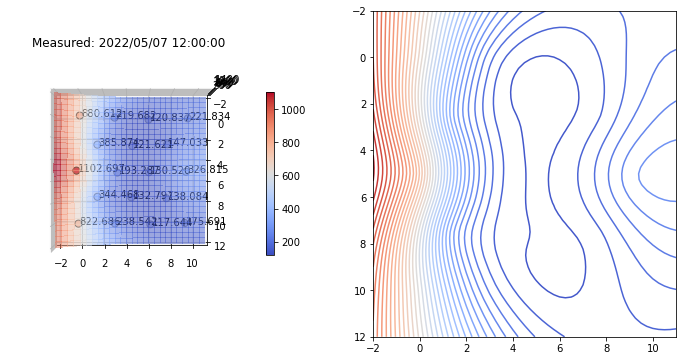

In [126]:
%matplotlib inline
for name,ss in time_df2.iterrows():
    #print(name)
    Real_suf(ss,area_pos,name='Measured: '+name)

<AxesSubplot:>

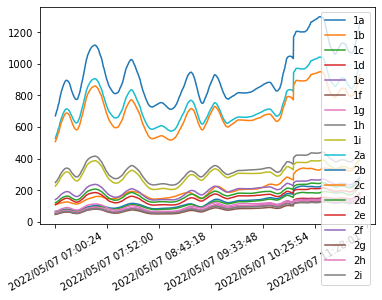

In [196]:
Time_point(Output,start=7,end=13,minute_sec=0.1).plot(rot=30)

<AxesSubplot:>

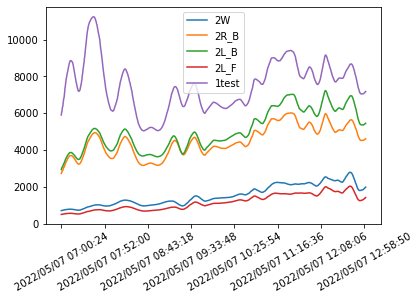

In [195]:
Time_point(Input,start=7,end=13,minute_sec=0.1).plot(rot=30)

In [127]:
import os
from dateutil import parser
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from matplotlib import cm
from datetime import datetime,time, tzinfo, timedelta

cwd = os.getcwd()
path = os.path.join(cwd, "lightModel", "Sun")
path_setting = 'new_result'

sun_model_df = pd.read_csv('Sun_weight.csv',index_col=0)
Input = pd.read_csv('Window.csv',index_col=0)
Output = pd.read_csv('Work_surf.csv',index_col=0)
area_pos = sun_model_df[['x','y']]

class Sun_model:
    def __init__ (self,delta=0.5,mn = [-1,-2],mx = [10,11]):
        self.sun_model_df = sun_model_df
        self.area_pos = area_pos
        self.Input = Input
        self.Output = Output
        self.delta = delta
        self.mn = mn
        self.mx = mx
        self.new_X,self.new_Y = np.meshgrid(np.arange(mn[0], mx[0]+delta, delta),
                                            np.arange(mn[1], mx[1]+delta, delta))
        self.xflat = np.dstack((self.new_X.flatten(),self.new_Y.flatten()))[0]
        self.med_win = '10s'
        self.mean_win = '60s'
        self.feature_col = sun_model_df.columns[:-2]
        self.sun_arr = sun_model_df[self.feature_col].values
    
    def Time_point(self,start=7,end=17,minute_sec=20,time_point=None,Win=True):
        start_point = datetime(2022,5,7,start,0,0)
        end_point = datetime(2022,5,7,end,0,0)
        nums = (end_point - start_point)/timedelta(minutes=minute_sec)
        if time_point==None:
            time_ps2 = [ (start_point+timedelta(minutes=minute_sec*i)).strftime('%Y/%m/%d %H:%M:%S') for i in range(int(nums))]
        else:
            time_ps2 = [datetime(2022,5,7).strftime('%Y/%m/%d ')+ time_point]
        if Win:
            df = self.Input.copy()
        else:
            df = self.Output.copy()
            
        ffs2 = df.dropna()
        time_df2 = pd.DataFrame([])
        for tp in time_ps2:
            if time_df2.empty:
                time_df2 = ffs2.loc[tp:].iloc[0:1]
            else:
                time_df2 = pd.concat([time_df2,ffs2.loc[tp:].iloc[0:1]])
        time_df2 = time_df2[~time_df2.index.duplicated(keep='first')]
        return time_df2
    
    def Work_lx_meas(self,input_work_lx,name='',draw=True):
        input_work_lx = pd.merge(input_work_lx.T,
                                 self.area_pos,left_index=True,right_index=True,how='left')#.sort_index()
        input_work_lx.columns = ['lux','x','y']
        ##xflat = np.dstack((self.new_X.flatten(),self.new_Y.flatten()))[0]
        model_rbf = RBFInterpolator(input_work_lx[['x','y']].values,
                                    input_work_lx["lux"].values.reshape(-1,1),
                                    smoothing=0.2)      
        
        yflat = model_rbf(self.xflat)
        y_grid = yflat.reshape(self.new_X.shape)
        
        if draw:
            fig = plt.figure(figsize=(12,6))
            ax = fig.add_subplot(1, 2, 1, projection='3d')
            ax.set_title(name)
            ax.plot_surface(self.new_Y,self.new_X, y_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=0.5)
            p = ax.scatter(input_work_lx['y'],input_work_lx['x'],input_work_lx['lux'],c=input_work_lx['lux'], 
                           s=50,ec='k',cmap=cm.coolwarm)
            for dd in input_work_lx[['y','x','lux']].values:
                label = '{0:.3f}'.format(dd[2])
                ax.text(dd[0]+0.1, dd[1]+0.1, dd[2], label,color='black')
            fig.colorbar(p,shrink=0.5)
            ax.view_init(elev=90, azim=-90)
            plt.ylim( self.mx[0], self.mn[0])
            plt.xlim( self.mn[1], self.mx[1])#mn[1], 
            ax = fig.add_subplot(1, 2, 2)
            contours = ax.contour(self.new_Y,self.new_X,  y_grid, 40, cmap=cm.coolwarm)
            ax.set_aspect('equal', 'box')
            plt.ylim(self.mx[0],self.mn[0])
            plt.xlim(self.mn[1],self.mx[1])
            plt.show()
        return y_grid  
    
    def Work_lx_pred(self,right=0,left=0,Real=False,sample=None,name='',draw=True):
        model = self.sun_model_df.copy()
        if not Real:
            in_ = [right]*3+[left]*2
            upper_left,center_left,lower_left,upper_right,center_right = in_
            sensor_mapping_dict = {
                '2W': center_right,
                '2R_B': lower_left,
                '2L_B': upper_left,
                '2L_F': upper_right,
                '1test': center_left
            }
            input_vector = np.array([sensor_mapping_dict[cc] for cc in self.feature_col])
        else:
            input_vector = np.array([sample[cc] for cc in self.feature_col])
        model['lux'] = self.sun_arr.dot(input_vector)
        model_rbf = RBFInterpolator(model[['x','y']].values,model["lux"].values.reshape(-1,1),smoothing=0.2)
        yflat = model_rbf(self.xflat)
        y_grid = yflat.reshape(self.new_X.shape)
        if draw:
            fig = plt.figure(figsize=(12,6))
            ax = fig.add_subplot(1, 2, 1, projection='3d')
            ax.set_title(name)
            # ax.set_title('Area: '+''lux")
            ax.plot_surface(self.new_Y,self.new_X, y_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=0.5)
            p = ax.scatter(model['y'],model['x'],model['lux'],c=model['lux'], s=50,ec='k',cmap=cm.coolwarm)
            for dd in model[['y','x','lux']].values:
                label = '{0:.3f}'.format(dd[2])
                ax.text(dd[0]+0.1, dd[1]+0.1, dd[2], label,color='black')
            fig.colorbar(p,shrink=0.5)
            ax.view_init(elev=90, azim=-90)
            plt.ylim( self.mx[0],self.mn[0])
            plt.xlim(self.mn[1],self.mx[1])#mn[1], 
            ax = fig.add_subplot(1, 2, 2)
            contours = ax.contour(self.new_Y,self.new_X,  y_grid, 40, cmap=cm.coolwarm)
            ax.set_aspect('equal', 'box')
            plt.ylim( self.mx[0],self.mn[0])
            plt.xlim(self.mn[1],self.mx[1])
            plt.show()
        return y_grid

In [255]:
sun = Sun_model()

input_temp = sun.Time_point(Win=True,time_point='10:00:20')#.plot()
b = sun.Work_lx_pred(sample=input_temp,Real=True)

input_temp = sun.Time_point(Win=False,time_point='10:00:20')#.plot()
b = sun.Work_lx_meas(input_temp)

input_temp = sun.Time_point(Win=True,start=7,end=12,minute_sec=60)#.plot()
for index,row in input_temp.iterrows():
    b = sun.Work_lx_pred(sample=row,Real=True,draw=False)